In [1]:
ENV='MiniHack-KeyRoom-S15-v0'
# ENV='MiniHack-CorridorBattle-v0'
H = 10
W = 10
NUM_EPISODES = 1
MAX_STEPS = 100
PATH = 'kbkey.pl'



In [2]:
from utilsk import decide_next_cell_to_explore, initialize,perform_action,coordinates_to_actions,astar,obschar_to_mask, actions, positions,  process_state, show_match
from pyswip import Prolog
import matplotlib.pyplot as plt
import numpy as np
import time


In [3]:
KB = Prolog()
KB.consult(PATH)

In [4]:
import gym
import minihack
import matplotlib.pyplot as plt
from minihack import LevelGenerator
from nle import nethack


map = """
--------------------------------------
|....................................|
|....................................|
|....................................|
|....................................|
|....................................|
|....................................|
|....................................|
||||||||.|||||.......................|
|............|.......................|
|............|.......................|
|............|.......................|
|............|.......................|
|............|.......................|
--------------------------------------
"""

lvl_gen = LevelGenerator(map=map, lit=True)
lvl_gen.set_start_pos((3, 6))
lvl_gen.add_door("closed", place=(8,8))
lvl_gen.add_object(name='skeleton key', symbol='(', place=(28,7))
lvl_gen.add_goal_pos((11, 10))

# map = """
# --------------------------------------
# |....................................|
# |..-----....|..|.............|.......|
# |..|   |..--|--|-------...------.....|
# |..--- |....|..|.....................|
# |....| ||......||....-----......|....|
# |....|  |-------.........|......|....|
# |....|  |................|||..|||....|
# ------  |-------....------......|....|
#         |......|................|..|||
#         |......--------.........|....|
#         |.............|---------|....|
#         |..............#########.....|
#         |.............|---------|....|
#         ------------------------------ 
# """

# lvl_gen = LevelGenerator(map=map, lit=False)
# lvl_gen.set_start_pos((3, 6))
# # lvl_gen.add_monster(name="giant rat", place=(10, 11))
# # lvl_gen.add_monster(name="giant rat", place=(10, 12))
# # lvl_gen.add_monster(name="giant rat", place=(10, 13))
# # lvl_gen.add_monster(name="giant rat", place=(11, 11))
# # lvl_gen.add_monster(name="giant rat", place=(11, 12))
# # lvl_gen.add_monster(name="giant rat", place=(11, 13))
# lvl_gen.add_door("closed", place=(32,12))
# lvl_gen.add_object(name='skeleton key', symbol='(', place=(28,7))
# lvl_gen.add_goal_pos((11, 10))

initialize()

MOVE_ACTIONS = tuple(nethack.CompassDirection)
NAVIGATE_ACTIONS = MOVE_ACTIONS + (
    nethack.Command.PICKUP,
    nethack.Command.OPEN
)

env = gym.make("MiniHack-Skill-Custom-v0",
               character="rog-hum-cha-mal",
               observation_keys=('screen_descriptions','chars','glyphs','inv_strs','blstats','message','pixel','pixel_crop'),
               des_file = lvl_gen.get_des(),
               max_episode_steps=600,
               actions = NAVIGATE_ACTIONS)
obs=env.reset() # each reset generates a new environment instance
env.render()





Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                                                                                
                                                                                
                                                                                
                    --------------------------------------                      
                    |....................................|                      
                    |....................................|                      
                    |....................................|                      
                    |....................................|                      
                    |....................................|                      
                    |..@.................................|                      
                    |...........................(........|                      
                    -------

east


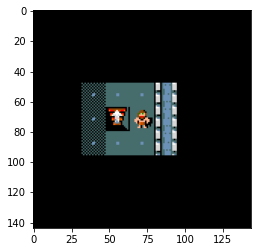

In [22]:
obs, reward, done, info=perform_action('east', env, KB,obs)
plt.imshow(obs['pixel_crop'])

In [10]:
process_state(obs, KB)
action = list(KB.query('standing_next(door)'))
action

[{}, {}, {}, {}]

In [8]:
action = list(KB.query('action(X)'))[0]["X"]
action

'go(stairs)'

In [12]:
positions["agent"], positions["door"]

((15, 52), (15, 52))

In [5]:
rewards = []
performed_acts=[]

def run(obs,performed_acts):
    initialize()

    # count the number of steps of the current episode
    steps = 0
    # store the cumulative reward
    reward = 0.0
    # collect obs['pixel'] to visualize
    ep_states = []

    # obs = env.reset()
    ep_states.append(obs['pixel'])
    done = False
    info=None

    # Main loop
    plan=[]
    while not done and steps < MAX_STEPS:
        # Get the observation from the env and assert the facts in the kb 
        process_state(obs, KB)

        # Query Prolog
        # Run the inference and get the action to perform
        # Get the first answer from Prolog -> the top-priority action
       
        action = list(KB.query('action(X)'))[0]["X"]
      
        # print(f'>> Current action from Prolog: {action}')
        
        if action:
            navs=[]
            if 'go(stairs)' in action:
                agent_p=positions['agent']
                stairs_p=positions['stairs']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, stairs_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)

            elif 'enter(door)' in action:
                agent_p=positions['agent']
                door_p=positions['door']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, door_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)
                
            elif 'opendoor' in action:
                obs, reward, done, info = perform_action("opendoor", env, KB,obs)
                performed_acts+=["opendoor"]
                steps += 1
                process_state(obs, KB)
                ep_states.append(obs['pixel'])
                env.render()
                
            elif "pick" in action:
                obs, reward, done, info = perform_action("pick", env, KB,obs)
                performed_acts+=["pick"]
                steps += 1
                process_state(obs, KB)
                ep_states.append(obs['pixel'])
                env.render()
                
            if "go(door)" in action:
                agent_p=positions['agent']
                door_p=positions['door_front']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, door_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)

                
            elif "go(key)" in action:
                agent_p=positions['agent']
                key_p=positions['key']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, key_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)
                
            elif 'explore' in action:
                b_cell=decide_next_cell_to_explore(obs)
                agent_p=positions['agent']
                masked=obschar_to_mask(obs)
                # print(agent_p,b_cell)
                path = astar(masked,agent_p, b_cell)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)

                
            for nav in navs:
                performed_acts+=[nav]

                if list(KB.query('action(X)'))[0]["X"] != action:
                    break
                    
                obs, reward, done, info = perform_action(nav, env, KB,obs)
                steps += 1
                process_state(obs, KB)
                ep_states.append(obs['pixel'])
                # env.render()
                
                

        else:
            print("ERROR: impossible to perform any action. Please check assertions and definitions in KB.")
            break


    # Display game with interface
    show_match(ep_states,0,600,250,1350)
    # show_match(ep_states,0,200,0,200)
    # Print information about the ended episode
    print(f'Episode {episode} - {steps} steps')
    print(f'End status: {info["end_status"].name}')
    print(f'Final reward: {reward}')
    time.sleep(0.75)

    # rewards.append(reward)

    # # reset the environment and retract axioms that may cause errors
    # obs = env.reset()
    # KB.retractall('stepping_on(agent,_,_)')
    


Episode 0 - 51 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
After 1 episodes, mean return is 0.0
The rewards of the episodes are: []


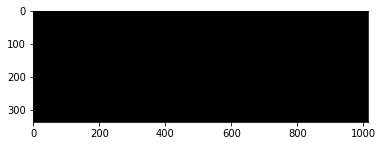

In [6]:
for episode in range(NUM_EPISODES):
    run(obs,performed_acts)
    


print(f'After {NUM_EPISODES} episodes, mean return is {sum(rewards)/NUM_EPISODES}')
print("The rewards of the episodes are:", rewards)

In [10]:
performed_acts

['east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'east',
 'southeast',
 'pick',
 'west',
 'west',
 'west',
 'west',
 'west',
 'west',
 'west',
 'west',
 'west',
 'west',
 'west',
 'west',
 'west',
 'west',
 'west',
 'west',
 'west',
 'west',
 'west',
 'west',
 'opendoor',
 'opendoor',
 'south',
 'southeast',
 'east',
 'southeast',
 'southeast',
 'east',
 'southeast',
 'southeast',
 'east',
 'southeast',
 'southeast',
 'east',
 'southeast',
 'southeast',
 'east',
 'southeast',
 'southeast',
 'east',
 'southeast',
 'southeast',
 'east',
 'southeast',
 'southeast',
 'east',
 'southeast',
 'southeast',
 'east',
 'southeast',
 'southeast',
 'east',
 'southeast',
 'southeast',
 'east',
 'southeast',
 'southeast',
 'east',
 'southeast',
 'southeast',
 'east',
 'southeast',
 'southeast',
 'east',
 'southeast',
 'southeast',
 'east',
 'so

In [11]:
env.render()


You can't move diagonally out of an intact doorway.                             
                                                                                
                                                                                
                                                                                
                    --------------------------------------                      
                    |....................................|                      
                    |....................................|                      
                    |....................................|                      
                    |....................................|                      
                    |....................................|                      
                    |..<.................................|                      
                    |....................................|                      
                    -------

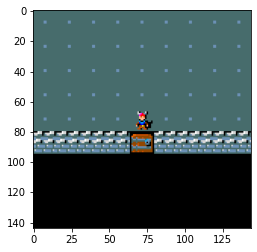

In [9]:
obs, reward, done, info=perform_action("opendoor", env, KB,obs)
plt.imshow(obs['pixel_crop'])

In [9]:
obs, reward, done, info = env.step(3)

RuntimeError: Called step on finished NetHack

In [10]:
 bytes(obs['message']).decode('utf-8').rstrip('\x00')

'You see no door there.'

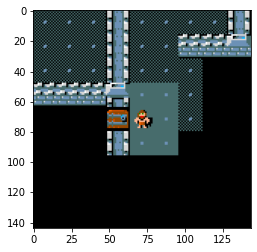

In [11]:
plt.imshow(obs['pixel_crop'])

In [5]:
for obj in obs['inv_strs']:
        obj = bytes(obj).decode('utf-8').rstrip('\x00')
        print(obj)

a +0 short sword (weapon in hand)
9 +0 daggers (alternate weapon; not wielded)
an uncursed +1 leather armor (being worn)
an uncursed potion of sickness
an uncursed lock pick
an empty uncursed sack



















































In [14]:
positions["door"], positions["agent"]

((11, 28), (10, 28))

In [17]:
for i in range(21):
        for j in range(79):
            if not (obs['screen_descriptions'][i][j] == 0).all():
                obj = bytes(obs['screen_descriptions'][i][j]).decode('utf-8').rstrip('\x00')
                print(obj,obs["chars"][i][j],obs['glyphs'][i][j])

wall 45 2362
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2361
wall 45 2363
wall 124 2360
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a room 46 2378
floor of a r

In [ ]:
obj = bytes(obs['screen_descriptions'][i][j]).decode('utf-8').rstrip('\x00')